# Lab CNN

Create a CNN that can classify flower types

## importing relevant packages for pre processing

In [48]:
import numpy as np
import PIL
import PIL.Image
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import kerastuner as kt



## Pre processing the data set

In [49]:
data_dir = pathlib.Path("Data/flowers") # Setting directory path as a variable for the flowers data set

In [50]:
image_count =len(list(data_dir.glob("*/*.jpg"))) # Doing an image count to check the amount of images within the dataset
image_count

4317

In [51]:
list(data_dir.glob("*/*.jpg"))[0:2] # Listing some of the images, This is instance [0:2] is the first folder and first 2 images

[PosixPath('Data/flowers/daisy/5435521200_92029bbe2b_n.jpg'),
 PosixPath('Data/flowers/daisy/34518066912_0e432507bc_n.jpg')]

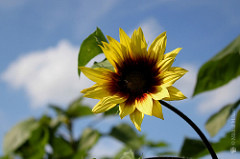

In [52]:
# checking to see if the images get displayed
sunflower = list(data_dir.glob("sunflower/*"))
PIL.Image.open(str(sunflower[0])) # checking first image in sunflower folder

### Creating and splitting the data set using keras utilities  

In [62]:
# I will have a few parameters that can change within the function these will include batch size, image width and height
# I will split the data in to a train at 80% and val 

def train_test_split(batch_size, img_width, img_height):

    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split = 0.2,
        subset = "training",
        seed = 123,
        image_size = ( img_height,img_width),
        batch_size = batch_size,)

    
    test_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        subset = "validation",
        validation_split=0.2,
        seed = 123,
        image_size = ( img_height, img_width),
        batch_size = batch_size,)

    return train_ds, test_ds


In [63]:
train_ds, test_ds = train_test_split(64,64,64)

Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [67]:
def keras_ds_to_numpy_array(train_ds, test_ds):
    
    train_images = []
    train_labels = []
    for batch in train_ds.as_numpy_iterator():
        train_images.append(batch[0])
        train_labels.append(batch[1])

    test_images = []
    test_labels = []
    for batch in test_ds.as_numpy_iterator():
        test_images.append(batch[0])
        test_labels.append(batch[1])

    train_images = np.concatenate(train_images)
    train_labels = np.concatenate(train_labels)
    test_images = np.concatenate(test_images)
    test_labels = np.concatenate(test_labels)

    print(f"Train Images shape:", {train_images.shape})
    print(f"Train Labels Shape:" ,{train_labels.shape})
    print(f"Number of Train Samples:", {len(train_images)})
    print(f"Number of Train labels:" ,{len(train_labels)})

    print(f"Test Images shape:", {test_images.shape})
    print(f"Test Labels Shape:" ,{test_labels.shape})
    print(f"Number of Test Samples:", {len(test_images)})
    print(f"Number of Test labels:", {len(test_labels)})

    return train_images, train_labels, test_images, test_labels

In [68]:
# testing the function with batchsize 32, height 180 and 180
train_images, train_labels, test_images, test_labels =  keras_ds_to_numpy_array(train_ds, test_ds)

Train Images shape: {(3454, 64, 64, 3)}
Train Labels Shape: {(3454,)}
Number of Train Samples: {3454}
Number of Train labels: {3454}
Test Images shape: {(863, 64, 64, 3)}
Test Labels Shape: {(863,)}
Number of Test Samples: {863}
Number of Test labels: {863}


In [69]:
# I need to also add class names so that the data has labels

class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


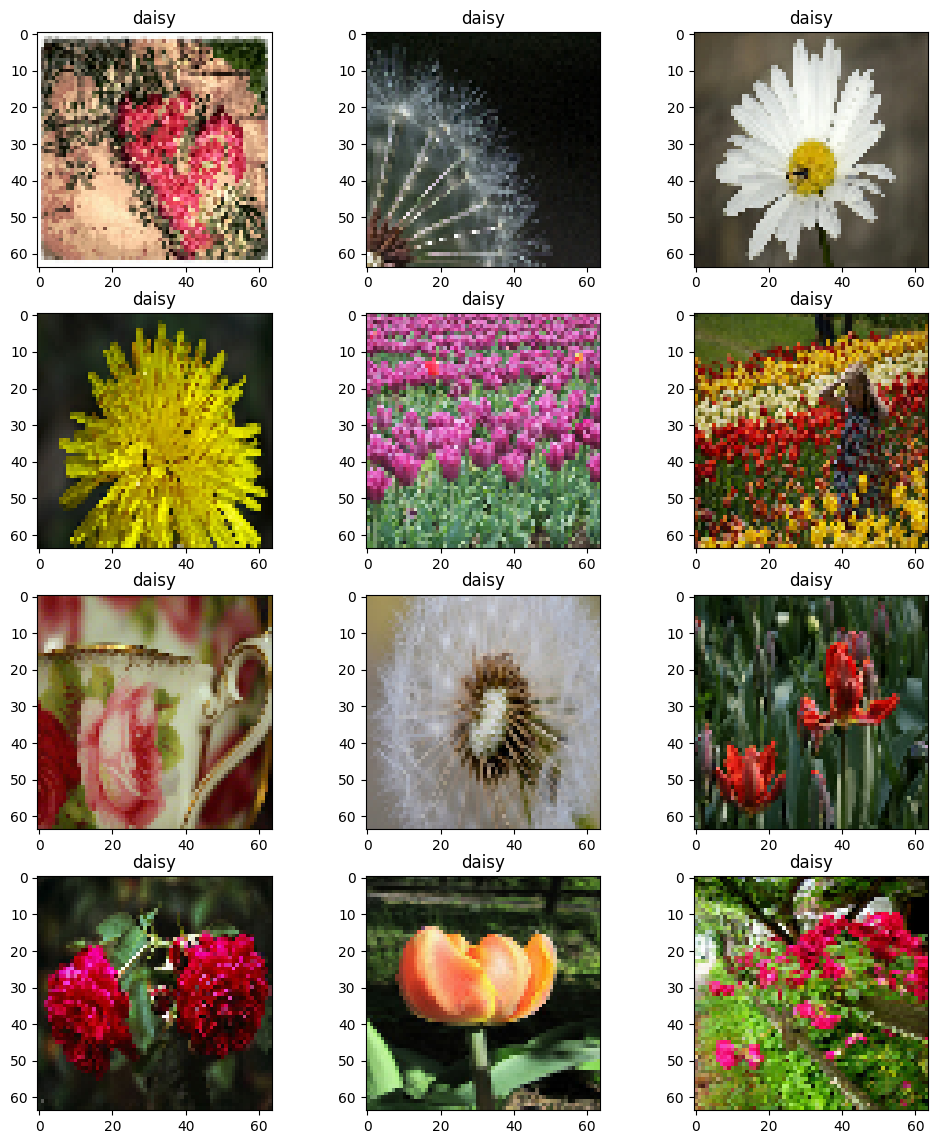

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,14))
for images, labels in train_ds.take(1):
    for i in range (12):
        ax = plt.subplot(4,3, i +1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        class_index = np.argmax(labels[i])

        plt.title(class_names[class_index])
        

## Building the model

I am going to use keras tuner to help find the best hyper parameters for my model. First i have to build a function that will have the different parameters that i will try to build the best model 

In [72]:
img_height = 64
img_width = 64

def model_builder(hp):
    
    model = tf.keras.Sequential()
    model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

    # input layer 
    model.add(layers.Conv2D(
        filters=hp.Int("input_filters", min_value=32, max_value=256, step=32),
        kernel_size=3,
        activation="relu",
        padding="same",
        input_shape=(img_height, img_width, 3)
    ))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))

    # convolution network layers : I will use a for loop that will determine what the best amount of layers will be for the model using the keras tuner
    for i in range(hp.Int("n_conv_layers", 1,4)):
        model.add(layers.Conv2D(
            filters=hp.Int(f"conv_{i}_filters", min_value=32, max_value=256, step=32),
            kernel_size=3,
            activation="relu",
            padding="same")
        )
        model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    model.add(layers.Flatten())
    for i in range(hp.Int("n_dense_layers", 1,4)):
        model.add(layers.Dense(
            units=hp.Choice(f"n_nodes_{i}", values= [10, 20, 50, 100]), #changed these to small values
            activation="relu")
        )
        
    model.add(layers.Dense(5))
    model.add(layers.Activation("softmax"))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])),
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=["accuracy"])
    
    return model

## Now I have created my model it is time to do run the keras tuner to find the best hyper parameters for my model

In [32]:
tuner = kt.BayesianOptimization(model_builder,
                        objective="accuracy",
                        max_trials= 10,
                        directory="tuner_results",
                        project_name="flowers",
                        
                        )

Reloading Tuner from tuner_results/flowers/tuner0.json


In [33]:
early_stopping = keras.callbacks.EarlyStopping(monitor="loss", patience=3)

In [36]:
tuner.search(train_images, train_labels epochs=5,validation_split=0.2, callbacks=[early_stopping])  #validation_split=0.2,


In [35]:
n_best_models = tuner.get_best_models(num_models=2)
print(n_best_models[0].summary())

best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print(best_hyperparameters.values)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 224)       129248    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 224)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 224)       4

In [38]:
img_height = 64
img_width = 64

def model_builder_2(hp):
    
    model = tf.keras.Sequential()
    model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

    # input layer 
    model.add(layers.Conv2D(
        filters=64,
        kernel_size=3,
        activation="relu",
        padding="same",
        input_shape=(img_height, img_width, 3)
    ))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))

    # convolution network layers : I will use a for loop that will determine what the best amount of layers will be for the model using the keras tuner
    model.add(layers.Conv2D(
            filters=224,
            kernel_size=3,
            activation="relu",
            padding="same")
        )
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(
            filters=224,
            kernel_size=3,
            activation="relu",
            padding="same")
        )
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
              
    model.add(layers.Conv2D(
            filters=128,
            kernel_size=3,
            activation="relu",
            padding="same")
        )
    model.add(layers.MaxPooling2D(pool_size=(2,2)))          

    model.add(layers.Flatten())
    
    model.add(layers.Dense(
            units=hp.Int(f"n_nodes_1", min_value=0, max_value=20, step=1 ),
            activation="relu")
        )

    model.add(layers.Dense(
            units=hp.Int(f"n_nodes_2", min_value=0, max_value=10, step=1),
            activation="relu")
        )   
    model.add(layers.Dense(5))
    model.add(layers.Activation("softmax"))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate= 1e-3),
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=["accuracy"])
    
    return model

In [39]:
fine_tuner = kt.BayesianOptimization(model_builder_2,
                        objective="accuracy",
                        max_trials= 10,
                        directory="tuner_results_fine",
                        project_name="flowers",
                        
                        )

In [40]:
fine_tuner.search(train_ds, epochs=5,validation_split=0.2, callbacks=[early_stopping])

Trial 2 Complete [00h 00m 00s]

Best accuracy So Far: None
Total elapsed time: 00h 00m 01s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
18                |5                 |n_nodes_1
10                |9                 |n_nodes_2



Traceback (most recent call last):
  File "/home/sam_glass/deep_learning/venv/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/home/sam_glass/deep_learning/venv/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/home/sam_glass/deep_learning/venv/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/home/sam_glass/deep_learning/venv/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/home/sam_glass/deep_learning/venv/lib/python3.10/site-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return mo

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/home/sam_glass/deep_learning/venv/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/home/sam_glass/deep_learning/venv/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/home/sam_glass/deep_learning/venv/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/home/sam_glass/deep_learning/venv/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/home/sam_glass/deep_learning/venv/lib/python3.10/site-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/home/sam_glass/deep_learning/venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/sam_glass/deep_learning/venv/lib/python3.10/site-packages/keras/src/engine/data_adapter.py", line 1776, in train_validation_split
    raise ValueError(
ValueError: `validation_split` is only supported for Tensors or NumPy arrays, found following types in the input: [<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>]


In [30]:
fine_best_models = fine_tuner.get_best_models(num_models=2)
print(n_best_models[0].summary())

fine_best_hyperparameters = fine_tuner.get_best_hyperparameters(1)[0]
print(best_hyperparameters.values)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 224)       129248    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 224)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 224)       4

### now i will train my model with best parameters

In [37]:
model = fine_tuner.hypermodel.build(fine_best_hyperparameters)

history = model.fit(train_ds, epochs=50, validation_split=0.2,callbacks=[early_stopping])

NameError: name 'fine_tuner' is not defined